In [67]:
## Load libraries
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from keras.datasets import mnist
plt.style.use('dark_background')
%matplotlib inline

In [68]:
## Mount Google drive folder if running in Colab
if('google.colab' in sys.modules):
    from google.colab import drive
    drive.mount('/content/drive', force_remount = True)
    DIR = '/content/drive/MyDrive/Colab Notebooks/MAHE/MSIS Coursework/EvenSem2024MAHE'
    DATA_DIR = DIR + '/Data/'
else:
    DATA_DIR = 'Data/'

In [69]:
np.set_printoptions(precision=2)

In [70]:
import tensorflow as tf

In [71]:
tf.__version__

'2.12.1'

---

Load MNIST Data

---

In [72]:
## Load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.transpose(1, 2, 0)
X_test = X_test.transpose(1, 2, 0)
X_train = X_train.reshape(X_train.shape[0]*X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0]*X_test.shape[1], X_test.shape[2])

num_labels = len(np.unique(y_train))
num_features = X_train.shape[0]
num_samples = X_train.shape[1]

# One-hot encode class labels
Y_train = tf.keras.utils.to_categorical(y_train).T
Y_test = tf.keras.utils.to_categorical(y_test).T


# Normalize the samples (images)
xmax = np.amax(X_train)
xmin = np.amin(X_train)
X_train = (X_train - xmin) / (xmax - xmin) # all train features turn into a number between 0 and 1
X_test = (X_test - xmin)/(xmax - xmin)

print('MNIST set')
print('---------------------')
print('Number of training samples = %d'%(num_samples))
print('Number of features = %d'%(num_features))
print('Number of output labels = %d'%(num_labels))

MNIST set
---------------------
Number of training samples = 60000
Number of features = 784
Number of output labels = 10


---

A generic layer class with forward and backward methods

----

In [73]:
class Layer:
  def __init__(self):
    self.input = None
    self.output = None

  def forward(self, input):
    pass

  def backward(self, output_gradient, learning_rate):
    pass

---

The softmax classifier steps for a batch of comprising $b$ samples represented as the $725\times b$-matrix (784 pixel values plus the bias feature absorbed as its last row) $$\mathbf{X} = \begin{bmatrix}\mathbf{x}^{(0)},\mathbf{x}^{(1)},\ldots,\mathbf{x}^{(b-1)}\end{bmatrix}$$ with one-hot encoded true labels represented as the $10\times b$-matrix (10 possible categories) $$\mathbf{Y}=\begin{bmatrix}\mathbf{y}^{(0)}&\ldots&\mathbf{y}^{(b-1)}\end{bmatrix}$$ using a randomly initialized $10\times725$-weights matrix $\mathbf{W}$:

1. Calculate $10\times b$-raw scores matrix : $$\begin{align*}\begin{bmatrix}\mathbf{z}^{(0)}&\ldots&\mathbf{z}^{(b-1)}\ldots\end{bmatrix} &= \mathbf{W}\begin{bmatrix}\mathbf{z}^{(0)}&\ldots&\mathbf{z}^{(b-1)}\ldots\end{bmatrix}\\&=\begin{bmatrix}\mathbf{W}\mathbf{z}^{(0)}&\ldots&\mathbf{W}\mathbf{z}^{(b-1)}\end{bmatrix}\\\Rightarrow \mathbf{Z} &= \mathbf{WX}.\end{align*}$$
2. Calculate $10\times b$-softmax predicted probabilities matrix: $$\begin{align*}\begin{bmatrix}\mathbf{a}^{(0)}&\ldots&\mathbf{a}^{(b-1)}\end{bmatrix} &= \begin{bmatrix}\text{softmax}\left(\mathbf{z}^{(0)}\right)&\ldots&\text{softmax}\left(\mathbf{z}^{(b-1)}\right)\end{bmatrix}\\\Rightarrow\mathbf{A} &= \text{softmax}(\mathbf{Z}).\end{align*}$$
3. Predicted probability matrix gets a new name: $\hat{\mathbf{Y}} = \mathbf{A}.$
4. The crossentropy (CCE) loss for the $i$th sample is $$L_i = \sum_{k=0}^9-y^{(i)}_k\log\left(\hat{y}^{(i)}_k\right) = -{\mathbf{y}^{(i)}}^\mathrm{T}\log\left(\mathbf{y}^{(i)}\right)$$ which leads to the average crossentropy (CCE) batch loss for the batch as:
$$\begin{align*}L &=\frac{1}{b}\left[L_0+\cdots+L_{b-1}\right]\\&=\frac{1}{b}\left[-{\mathbf{y}^{(0)}}^{\mathrm{T}}\log\left(\hat{\mathbf{y}}^{(0)}\right)+\cdots+-{\mathbf{y}^{(b-1)}}^{\mathrm{T}}\log\left(\hat{\mathbf{y}}^{(b-1)}\right)\right].\end{align*}.$$
5. The computational graph for the samples in the batch are presented below:

$\hspace{1.5in}\begin{align*}L_0\\{\color{yellow}\downarrow}\\ \hat{\mathbf{y}}^{(0)} &= \mathbf{a}^{(0)}\\{\color{yellow}\downarrow}\\\mathbf{z}^{(0)}\\{\color{yellow}\downarrow}\\\mathbf{W}\end{align*}$$\qquad\cdots\qquad$$\begin{align*} L_{b-1}\\{\color{yellow}\downarrow}\\ \hat{\mathbf{y}}^{(b-1)} &= \mathbf{a}^{(b-1)}\\{\color{yellow}\downarrow}\\\mathbf{z}^{(b-1)}\\{\color{yellow}\downarrow}\\\mathbf{W}\end{align*}$
6. Calculate the gradient of the average batch loss w.r.t. weights as: $$\begin{align*}\Rightarrow \nabla_\mathbf{W}(L) &= \frac{1}{b}\left(\underbrace{\left[\nabla_\mathbf{W}\left(\mathbf{z}^{(0)}\right) \times\nabla_{\mathbf{z}^{(0)}}\left(\hat{\mathbf{y}}^{(0)}\right)\times\nabla_{\hat{\mathbf{y}}^{(0)}}(L_0)\right]}_{\text{sample}\,0}+\cdots+\underbrace{\left[\nabla_\mathbf{W}\left(\mathbf{z}^{(b-1)}\right) \times\nabla_{\mathbf{z}^{(b-1)}}\left(\hat{\mathbf{y}}^{(b-1)}\right)\times\nabla_{\hat{\mathbf{y}}^{(b-1)}}(L_{b-1})\right]}_{\text{sample}\,b-1}\right)\\&=\frac{1}{b}\left(\underbrace{\left[\nabla_\mathbf{W}\left(\mathbf{z}^{(0)}\right) \times\nabla_{\mathbf{z}^{(0)}}\left({\mathbf{a}}^{(0)}\right)\times\nabla_{\hat{\mathbf{y}}^{(0)}}(L_0)\right]}_{\text{sample}\,0}+\cdots+\underbrace{\left[\nabla_\mathbf{W}\left(\mathbf{z}^{(b-1)}\right) \times\nabla_{\mathbf{z}^{(b-1)}}\left(\hat{\mathbf{y}}^{(b-1)}\right)\times\nabla_{\hat{\mathbf{y}}^{(b-1)}}(L_{b-1})\right]}_{\text{sample}\,b-1}\right).\end{align*}$$
which can be written as $\nabla_\mathbf{W}(L)=$

![](https://onedrive.live.com/embed?resid=37720F927B6DDC34%21103292&authkey=%21AMoosVj6GqUSvpc&width=660)


---

---

CCE loss and its gradient for the batch samples:

$$\begin{align*}L &=\frac{1}{b}\left[L_0+\cdots+L_{b-1}\right]\\&=\frac{1}{b}\left[-{\mathbf{y}^{(0)}}^{\mathrm{T}}\log\left(\hat{\mathbf{y}}^{(0)}\right)+\cdots+-{\mathbf{y}^{(b-1)}}^{\mathrm{T}}\log\left(\hat{\mathbf{y}}^{(b-1)}\right)\right].\end{align*}$$

$$\begin{align*}\begin{bmatrix}\nabla_{\hat{\mathbf{y}}^{(0)}}(L_0)&\ldots&\nabla_{\hat{\mathbf{y}}^{(b-1)}}(L_{b-1})\end{bmatrix}=\begin{bmatrix}-y_0^{(0)}/\hat{y}_0^{(0)}&\cdots&-y_0^{(b-1)}/\hat{y}_0^{(b-1)}\\-y_1^{(0)}/\hat{y}_1^{(0)}&\ldots&-y_1^{(b-1)}/\hat{y}_1^{(b-1)}\\-y_2^{(0)}/\hat{y}_2^{(0)}&\cdots&-y_2^{(b-1)}/\hat{y}_2^{(b-1)}\\\vdots\\-y_9^{(0)}/\hat{y}_9^{(0)}&\cdots&-y_9^{(b-1)}/\hat{y}_9^{(b-1)}\end{bmatrix}.\end{align*}$$


---

In [74]:
## Define the loss function and its gradient
def cce(Y, Yhat):
  return(np.mean(np.sum(-Y*np.log(Yhat), axis = 0)))
  #TensorFlow in-built function for categorical crossentropy loss
  #cce = tf.keras.losses.CategoricalCrossentropy()
  #return(cce(Y, Yhat).numpy())

def cce_gradient(Y, Yhat):
  return(-Y/Yhat)

Generic activation layer class:

**Forward**:
$$\begin{align*}\begin{bmatrix}\mathbf{a}^{(0)}&\ldots&\mathbf{a}^{(b-1)}\end{bmatrix} &= \begin{bmatrix}\sigma\left(\mathbf{z}^{(0)}\right)&\ldots&\sigma\left(\mathbf{z}^{(b-1)}\right)\end{bmatrix}\\\Rightarrow\mathbf{A} &= \sigma(\mathbf{Z}).\end{align*}$$

**Backward**:
$$\begin{align*}\begin{bmatrix}\nabla_{\mathbf{z}^{(0)}}(L_0)&\ldots&\nabla_{\mathbf{z}^{(b-1)}}(L_{b-1})\end{bmatrix} &= \begin{bmatrix}\nabla_{\mathbf{z}^{(0)}}\left({\mathbf{a}}^{(0)}\right)\times\nabla_{\mathbf{a}^{(0)}}(L_0)&\cdots&\nabla_{\mathbf{z}^{(b-1)}}\left({\mathbf{a}}^{(b-1)}\right)\times\nabla_{\mathbf{a}^{(b-1)}}(L_{b-1})\end{bmatrix}\\&=\begin{bmatrix}\text{diag}\left(\nabla_{\mathbf{z}^{(0)}}\left(\sigma\left(\mathbf{z}^{(0)}\right)\right)\right)\times\nabla_{\mathbf{a}^{(0)}}(L_0)&\ldots&\text{diag}\left(\nabla_{\mathbf{z}^{(b-1)}}\left(\sigma\left(\mathbf{z}^{(b-1)}\right)\right)\right)\times\nabla_{\mathbf{a}^{(b-1)}}(L_{b-1})\end{bmatrix}.\end{align*}$$



In [75]:
class Activation(Layer):
    def __init__(self, activation, activation_gradient):
        self.activation = activation
        self.activation_gradient = activation_gradient

    def forward(self, input):
        self.input = input
        self.output = self.activation(self.input)
        return(self.output)

    def backward(self, output_gradient, learning_rate = None):
        return(output_gradient[:-1, :] * self.activation_gradient(self.input))

Specific activation layer classes:

In [76]:
class Sigmoid(Activation):
    def __init__(self):
        def sigmoid(z):
            return 1 / (1 + np.exp(-z))

        def sigmoid_gradient(z):
            a = sigmoid(z)
            return a * (1 - a)

        super().__init__(sigmoid, sigmoid_gradient)

class Tanh(Activation):
    def __init__(self):
        def tanh(z):
            return np.tanh(z)

        def tanh_gradient(z):
            return 1 - np.tanh(z) ** 2

        super().__init__(tanh, tanh_gradient)

class ReLU(Activation):
    def __init__(self):
        def relu(z):
            return z * (z > 0)

        def relu_gradient(z):
            return 1. * (z > 0)

        super().__init__(relu, relu_gradient)

---

Softmax activation layer class:

**Forward**:
$$\begin{align*}\begin{bmatrix}\mathbf{a}^{(0)}&\ldots&\mathbf{a}^{(b-1)}\end{bmatrix} &= \begin{bmatrix}\text{softmax}\left(\mathbf{z}^{(0)}\right)&\ldots&\text{softmax}\left(\mathbf{z}^{(b-1)}\right)\end{bmatrix}\\\Rightarrow\mathbf{A} &= \text{softmax}(\mathbf{Z}).\end{align*}$$

**Backward**:
$$\begin{align*}\begin{bmatrix}\nabla_{\mathbf{z}^{(0)}}(L_0)&\ldots&\nabla_{\mathbf{z}^{(b-1)}}(L_{b-1})\end{bmatrix} &= \begin{bmatrix}\nabla_{\mathbf{z}^{(0)}}\left({\mathbf{a}}^{(0)}\right)\times\nabla_{\mathbf{a}^{(0)}}(L_0)&\cdots&\nabla_{\mathbf{z}^{(b-1)}}\left({\mathbf{a}}^{(b-1)}\right)\times\nabla_{\mathbf{a}^{(b-1)}}(L_{b-1})\end{bmatrix}\end{align*}$$

![](https://onedrive.live.com/embed?resid=37720F927B6DDC34%21103299&authkey=%21AIPPR63BJ3UybA8&width=928&height=99)


---

In [77]:
## Softmax activation layer class
class Softmax(Layer):
  def forward(self, input):
    self.output = tf.nn.softmax(input, axis = 0).numpy()

  def backward(self, output_gradient, learning_rate = None):
    ## Following is the inefficient way of calculating the backward gradient
    softmax_gradient = np.empty((self.output.shape[0], output_gradient.shape[1]), dtype = np.float64)
    for b in range(softmax_gradient.shape[1]):
      softmax_gradient[:, b] = np.dot((np.identity(self.output.shape[0])-np.atleast_2d(self.output[:, b])) * np.atleast_2d(self.output[:, b]).T, output_gradient[:, b])
    return(softmax_gradient)
    ## Following is the efficient way of calculating the backward gradient
    #T = np.transpose(np.identity(self.output.shape[0]) - np.atleast_2d(self.output).T[:, np.newaxis, :], (2, 1, 0)) * np.atleast_2d(self.output)
    #return(np.einsum('jik, ik -> jk', T, output_gradient))

---

Dense layer class:

**Forward**:
$$$$\begin{align*}\begin{bmatrix}\mathbf{z}^{(0)}&\ldots&\mathbf{z}^{(b-1)}\ldots\end{bmatrix} &= \mathbf{W}\begin{bmatrix}\mathbf{z}^{(0)}&\ldots&\mathbf{z}^{(b-1)}\ldots\end{bmatrix}\\&=\begin{bmatrix}\mathbf{W}\mathbf{z}^{(0)}&\ldots&\mathbf{W}\mathbf{z}^{(b-1)}\end{bmatrix}\\\Rightarrow \mathbf{Z} &= \mathbf{WX}.\end{align*}$$$$

**Backward**:
$$\begin{align*}\nabla_\mathbf{W}(L)&=\frac{1}{b}\left[\nabla_{\mathbf{W}}(\mathbf{z}^{(0)})\times\nabla_{\mathbf{z^{(0)}}}(L) +\cdots+ \nabla_{\mathbf{W}}(\mathbf{z}^{(b-1)})\times\nabla_{\mathbf{z^{(b-1)}}}(L)\right]\\&=\frac{1}{b}\left[\nabla_{\mathbf{z^{(0)}}}(L){\mathbf{x}^{(0)}}^\mathrm{T}+\cdots+\nabla_{\mathbf{z^{(b-1)}}}(L) {\mathbf{x}^{(b-1)}}^\mathrm{T}\right].\end{align*}$$

---

In [78]:
## Dense layer class
class Dense(Layer):
    def __init__(self, input_size, output_size, reg_strength):
        self.weights = 0.01*np.random.randn(output_size, input_size+1) # bias trick
        self.weights[:, -1] = 0.01 # set all bias values to the same nonzero constant
        self.reg_strength = reg_strength
        self.reg_loss = None
 
    def forward(self, input):
        self.input = np.vstack([input, np.ones((1, input.shape[1]))]) # bias trick
        self.output= np.dot(self.weights, self.input)
        self.reg_loss = self.reg_strength * np.sum(self.weights[:,:-1] * self.weights[:,:-1])
 
    def backward(self, output_gradient, learning_rate):
        ## Following is the inefficient way of calculating the backward gradient
        weights_gradient = np.zeros((self.output.shape[0], self.input.shape[0]), dtype = np.float64)
        # for b in range(output_gradient.shape[1]):
        #   weights_gradient += np.dot(output_gradient[:, b].reshape(-1, 1), self.input[:, b].reshape(-1, 1).T)
        # weights_gradient = (1/output_gradient.shape[1])*weights_gradient
 
        ## Following is the efficient way of calculating the backward gradient
        weights_gradient = (1/output_gradient.shape[1])*np.dot(np.atleast_2d(output_gradient), np.atleast_2d(self.input).T)
        ## Add regularization gradient here
        weights_gradient += self.reg_strength * 2 * np.hstack([self.weights[:,:-1], np.zeros((self.weights.shape[0],1))])
 
        input_gradient = np.dot(self.weights.T, output_gradient)
 
        # Update weights using gradient descent step
        self.weights = self.weights + learning_rate * (-weights_gradient)
 
        return(input_gradient)


---

Function to generate sample indices for batch processing according to batch size

---

In [79]:
## Function to generate sample indices for batch processing according to batch size
def generate_batch_indices(num_samples, batch_size):
  # Reorder sample indices
  reordered_sample_indices = np.random.choice(num_samples, num_samples, replace = False)
  # Generate batch indices for batch processing
  batch_indices = np.split(reordered_sample_indices, np.arange(batch_size, len(reordered_sample_indices), batch_size))
  return(batch_indices)

---

Example generation of batch indices

---

In [80]:
## Example generation of batch indices
batch_size = 16
batch_indices = generate_batch_indices(num_samples, batch_size)
print(batch_indices)

[array([58389, 36080, 42705, 22106, 31845, 43681, 31829, 12308, 42724,
       32766, 56686,  2149,  8169, 20416, 53012, 57688]), array([49380, 34690, 53639,  2244, 37284,  9412, 41119, 34954, 23245,
         257, 39293, 36917, 29998, 15054, 36394, 49691]), array([37464, 16059, 22630, 52856,  9430, 42152, 54055, 56088, 53753,
       53015, 57623, 10374, 16090, 57122, 30863, 56998]), array([10462, 38156, 51343, 49524,  8446, 56029, 41697, 28303,  4853,
        2229, 27085,  4906, 30882, 36912, 53221, 25684]), array([12294,  1815,  6012, 37786,  2962,  1830, 23615,  6747, 19926,
       20723, 38280,  8999, 19941,  3340, 59213, 36133]), array([10908, 16539, 12339, 39213, 38647, 23606, 36041, 59548, 36757,
       35457, 10866, 50894, 38557, 22265, 32121, 47168]), array([37546, 35120, 13550, 42215,  8746, 45200, 51368, 10685, 30535,
       59628,  3474, 39857, 18423, 40594, 26181, 33987]), array([57139, 30661, 25977, 36264, 22951, 26697, 35964, 28883, 22754,
       28674, 22364, 30528, 43711

---

Train the 1 hidden layer neural network using batch training with batch size = 16

---

In [87]:
## Train the 1 hidden layer neural network using batch training with batch size = 16
learning_rate = 1e-1 # learning rate
batch_size = 100 # batch size
nepochs = 100 # number of epochs
loss_epoch = np.empty(nepochs, dtype = np.float64) # create empty array to store losses over each epoch
loss_train_epoch = np.empty(nepochs, dtype = np.float64) # create empty array to store training losses over each epoch
loss_test_epoch = np.empty(nepochs, dtype = np.float64) # create empty array to store test losses over each epoch
reg_strength = 1e-3 # regularization strength
#add early stopping to avoid overfitting



# Neural network architecture
#dlayer = Dense(num_features, num_labels) # define dense layer
#softmax = Softmax() # define softmax activation layer

dlayer1 = Dense(num_features, 128, reg_strength) # define dense layer 1
alayer1 = ReLU() # ReLU activation layer 1
dlayer2 = Dense(128, num_labels, reg_strength) # define dense layer 2
softmax = Softmax() # define softmax activation layer

# Steps: run over each sample in the batch, calculate loss, gradient of loss,
# and update weights.

epoch = 0
while epoch < nepochs:
  batch_indices = generate_batch_indices(num_samples, batch_size)
  loss = 0
  for b in range(len(batch_indices)):
    #forward prop for training data
    dlayer1.forward(X_train[:, batch_indices[b]]) # forward prop dense layer 1 with batch feature added
    alayer1.forward(dlayer1.output) # forward prop activation layer 1
    dlayer2.forward(alayer1.output) # forward prop dense layer 2
    softmax.forward(dlayer2.output) # Softmax activate
    loss += cce(Y_train[:, batch_indices[b]], softmax.output) # calculate loss for the taining data
    #add regularization loss
    loss += dlayer1.reg_loss + dlayer2.reg_loss
    
    # Backward prop starts here
    grad = cce_gradient(Y_train[:, batch_indices[b]], softmax.output)
    grad = softmax.backward(grad)
    grad = dlayer2.backward(grad, learning_rate)
    grad = alayer1.backward(grad)
    grad = dlayer1.backward(grad, learning_rate)
  #calculate the average loss over current epoch
  loss_train_epoch[epoch] = loss/len(batch_indices)
  
  #forward prop for test data
  dlayer1.forward(X_test) # forward prop dense layer 1 with batch feature added
  alayer1.forward(dlayer1.output) # forward prop activation layer 1
  dlayer2.forward(alayer1.output) # forward prop dense layer 2
  softmax.forward(dlayer2.output) # Softmax activate
  
  #calculate the test loss
  loss_test_epoch[epoch] = cce(Y_test, softmax.output) # calculate loss for the taining data
  #add regularization loss
  loss_test_epoch[epoch] += dlayer1.reg_loss + dlayer2.reg_loss
  
  #print train loss and test loss for current epoch
  print('Epoch %d: train loss = %f, test loss = %f'%(epoch+1, loss_train_epoch[epoch], loss_test_epoch[epoch]))
  
  # loss_epoch[epoch] = loss/len(batch_indices)
  print('Epoch %d: loss = %f'%(epoch+1, loss_epoch[epoch]))
  epoch = epoch + 1

Epoch 1: train loss = 0.714015, test loss = 0.375244
Epoch 1: loss = 0.000000
Epoch 2: train loss = 0.361520, test loss = 0.322820
Epoch 2: loss = 1.000000
Epoch 3: train loss = 0.320098, test loss = 0.298159
Epoch 3: loss = 2.000000
Epoch 4: train loss = 0.294692, test loss = 0.285058
Epoch 4: loss = 3.000000
Epoch 5: train loss = 0.277810, test loss = 0.271120
Epoch 5: loss = 4.000000
Epoch 6: train loss = 0.266699, test loss = 0.261563
Epoch 6: loss = 5.000000
Epoch 7: train loss = 0.258111, test loss = 0.253532
Epoch 7: loss = 6.000000
Epoch 8: train loss = 0.252202, test loss = 0.253694
Epoch 8: loss = 7.000000
Epoch 9: train loss = 0.247421, test loss = 0.245154
Epoch 9: loss = 8.000000
Epoch 10: train loss = 0.243676, test loss = 0.243209
Epoch 10: loss = 9.000000
Epoch 11: train loss = 0.241005, test loss = 0.240647
Epoch 11: loss = 10.000000
Epoch 12: train loss = 0.238426, test loss = 0.239117
Epoch 12: loss = 11.000000
Epoch 13: train loss = 0.236763, test loss = 0.237643
Ep

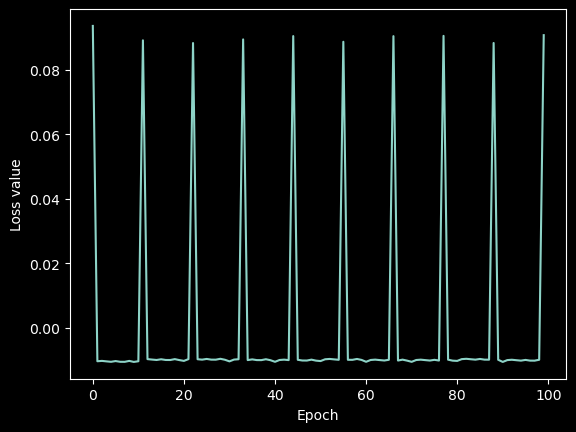

In [84]:
# Plot training loss as a function of epoch:
plt.plot(loss_epoch)
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.show()

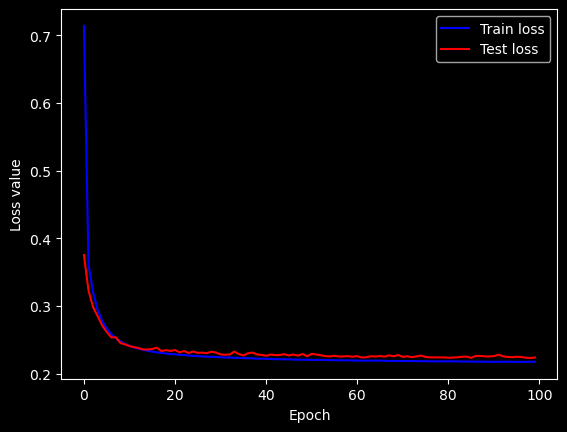

In [94]:
#plot the 2 numpy arrays and color code them and add legend
plt.plot(loss_train_epoch, label = 'Train loss',color='b')
plt.plot(loss_test_epoch, label = 'Test loss',color='r')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.legend()
plt.show()

In [105]:
dlayer1.forward(X_test)
alayer1.forward(dlayer1.output)
dlayer2.forward(alayer1.output)
softmax.forward(dlayer2.output)
ypred = np.argmax(softmax.output.T, axis = 1)
print(ypred)
ytrue = np.argmax(Y_test.T, axis = 1)
print(ytrue)
np.mean(ytrue == ypred)


[7 2 1 ... 4 8 6]
[7 2 1 ... 4 5 6]


0.836

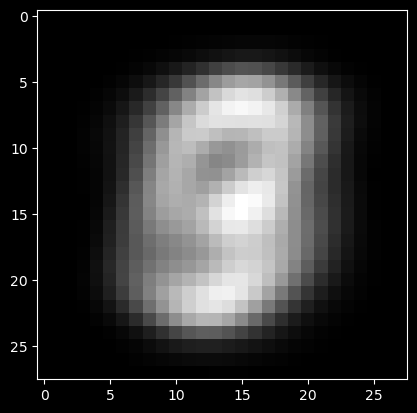

In [140]:
#plot a mean centered image
plt.imshow(np.mean(X_train, axis = 1).reshape(28, 28), cmap = cm.gray)
plt.show()



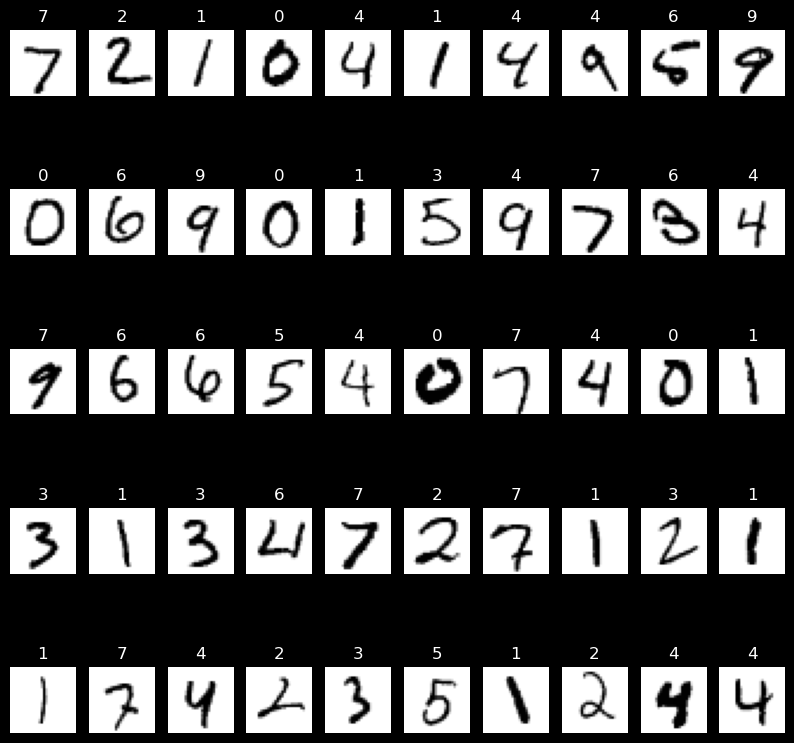

In [137]:
# Plot the first 50 test images and their predicted labels
fig, ax = plt.subplots(5, 10, figsize=(10, 10))
for i in range(50):
  ax[i // 10, i % 10].imshow(X_test[:, i].reshape(28, 28), cmap=cm.gray_r)
  ax[i // 10, i % 10].set_title(ypred[i])
  ax[i // 10, i % 10].axis('off')
plt.show()


In [ ]:
## Train the 1 hidden layer neural network using batch training with batch size = 16
learning_rate = 1e-1 # learning rate
batch_size = 100 # batch size
nepochs = 10 # number of epochs
loss_epoch = np.empty(nepochs, dtype = np.float64) # create empty array to store losses over each epoch
loss_train_epoch = np.empty(nepochs, dtype = np.float64) # create empty array to store training losses over each epoch
loss_test_epoch = np.empty(nepochs, dtype = np.float64) # create empty array to store test losses over each epoch
reg_strength = 1e-3 # regularization strength
#add early stopping to avoid overfitting

# Neural network architecture
#dlayer = Dense(num_features, num_labels) # define dense layer
#softmax = Softmax() # define softmax activation layer

dlayer1 = Dense(num_features, 128, reg_strength) # define dense layer 1
alayer1 = ReLU() # ReLU activation layer 1
dlayer2 = Dense(128, num_labels, reg_strength) # define dense layer 2
softmax = Softmax() # define softmax activation layer

def predict(X):
    dlayer1.forward(X) # forward prop dense layer 1 with batch feature added
    alayer1.forward(dlayer1.output) # forward prop activation layer 1
    dlayer2.forward(alayer1.output) # forward prop dense layer 2
    softmax.forward(dlayer2.output) # Softmax activate
    return np.argmax(softmax.output.T, axis=1)

# Steps: run over each sample in the batch, calculate loss, gradient of loss,
# and update weights.

epoch = 0
while epoch < nepochs:
    batch_indices = generate_batch_indices(num_samples, batch_size)
    loss = 0
    for b in range(len(batch_indices)):
        #forward prop for training data
        dlayer1.forward(X_train[:, batch_indices[b]]) # forward prop dense layer 1 with batch feature added
        alayer1.forward(dlayer1.output) # forward prop activation layer 1
        dlayer2.forward(alayer1.output) # forward prop dense layer 2
        softmax.forward(dlayer2.output) # Softmax activate
        loss += cce(Y_train[:, batch_indices[b]], softmax.output) # calculate loss for the taining data
        #add regularization loss
        loss += dlayer1.reg_loss + dlayer2.reg_loss

        # Backward prop starts here
        grad = cce_gradient(Y_train[:, batch_indices[b]], softmax.output)
        grad = softmax.backward(grad)
        grad = dlayer2.backward(grad, learning_rate)
        grad = alayer1.backward(grad)
        grad = dlayer1.backward(grad, learning_rate)
    #calculate the average loss over current epoch
    loss_train_epoch[epoch] = loss/len(batch_indices)

    #forward prop for test data
    dlayer1.forward(X_test) # forward prop dense layer 1 with batch feature added
    alayer1.forward(dlayer1.output) # forward prop activation layer 1
    dlayer2.forward(alayer1.output) # forward prop dense layer 2
    softmax.forward(dlayer2.output) # Softmax activate

    #calculate the test loss
    loss_test_epoch[epoch] = cce(Y_test, softmax.output) # calculate loss for the taining data
    #add regularization loss
    loss_test_epoch[epoch] += dlayer1.reg_loss + dlayer2.reg_loss

    #print train loss and test loss for current epoch
    print('Epoch %d: train loss = %f, test loss = %f'%(epoch+1, loss_train_epoch[epoch], loss_test_epoch[epoch]))

    # loss_epoch[epoch] = loss/len(batch_indices)
    print('Epoch %d: loss = %f'%(epoch+1, loss_epoch[epoch]))
    epoch = epoch + 1
